# Proyecto: Salarios en la ciencia de datos

**Presentaci√≥n & prop√≥sito**

An√°lisis del dataset `ds_salaries.csv`. Este conjunto de datos re√∫ne reportes salariales para roles de Data & AI (principalmente 2023). Su objetivo es permitir benchmarking, an√°lisis de mercado y preparar los datos para modelos predictivos de salario.

Resumen:
- Cobertura temporal: 2020‚Äì2023 (predominantemente 2023).
- √Åmbito: salarios por rol, convertidos a USD (`salary_in_usd`) junto con moneda original (`salary_currency`).
- Dimensiones clave: `job_title`, `experience_level`, `employee_residence`, `company_location`, `remote_ratio`, `company_size`.

Riesgos y consideraciones:
- Revisar conversiones de moneda y outliers (p.ej. salarios en INR con cifras locales altas pero `salary_in_usd` bajas).
- Homogeneizar `job_title` en familias para an√°lisis robustos.

## Tabla de variables

A continuaci√≥n se presenta una tabla con las variables del dataset, su tipo, una breve descripci√≥n, un ejemplo y notas de calidad.

| Variable | Tipo | Descripci√≥n | Ejemplo | Notas |
|---|---:|---|---|---|
| `work_year` | int | A√±o del reporte salarial | `2023` | Uso para an√°lisis temporal; pocos a√±os presentes |
| `experience_level` | categor√≠a (EN/MI/SE/EX) | Nivel de experiencia del empleado | `SE` | Mapear a orden: EN < MI < SE < EX |
| `employment_type` | categor√≠a (FT/CT/FL/PT) | Tipo de contrataci√≥n | `FT` | Normalizar etiquetas |
| `job_title` | string | T√≠tulo del puesto | `Data Scientist` | Agrupar en `job_family` para an√°lisis agregados |
| `salary` | float | Salario en moneda local | `1650000` (INR) | No comparar directamente entre monedas |
| `salary_currency` | string | C√≥digo ISO de moneda | `INR`, `USD`, `EUR` | Validar consistencia (3 letras) |
| `salary_in_usd` | float | Salario convertido a USD | `20984` | Usar para comparaciones internacionales |
| `employee_residence` | string (ISO pa√≠s) | Pa√≠s de residencia del empleado | `IN` | Validar c√≥digos y homogeneizar |
| `remote_ratio` | int (0/50/100) | Porcentaje de trabajo remoto | `100` | Mapear a `remote`/`hybrid`/`on-site` |
| `company_location` | string (ISO pa√≠s) | Pa√≠s de la sede de la compa√±√≠a | `US` | Comparar con `employee_residence` |
| `company_size` | categor√≠a (S/M/L) | Tama√±o aproximado de la empresa | `L` | Evaluar impacto en salario |

**Notas adicionales:**
- Se recomienda crear una columna `job_family` que agrupe t√≠tulos similares (p.ej. "Data Scientist", "Applied Scientist" ‚Üí "Data Scientist").
- Marcar y revisar filas con `salary_in_usd <= 1000` o `salary_in_usd > 1_000_000` como posibles outliers.
- Documentar cualquier regla de limpieza en el notebook para reproducibilidad.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv('ds_salaries.csv')
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

### Preprocesamiento de datos: ¬øQu√© estamos haciendo y por qu√©?


Primero, ¬øqu√© buscamos con estas celdas iniciales?
- Realizar controles b√°sicos de calidad (sanity checks) para entender la estructura del dato y detectar problemas evidentes.
- Limpiar el dataset de artefactos simples (como duplicados id√©nticos) que podr√≠an sesgar estad√≠sticas en el EDA.
- Documentar cada decisi√≥n para mantener trazabilidad y facilitar revisiones posteriores.

Qu√© hace cada bloque y por qu√© lo hacemos

1) Comprobaci√≥n de valores faltantes (`df.isnull().sum()`)

Al ejecutar esta celda obtenemos el conteo de valores ausentes por columna. Esto nos permite priorizar columnas que necesitan atenci√≥n: por ejemplo, si `salary_in_usd` tiene valores faltantes deberemos decidir entre imputar o descartar esos registros. Este chequeo es informativo: no modificamos datos todav√≠a, s√≥lo registramos el estado actual para decidir la estrategia m√°s adecuada.

2) Inspecci√≥n del tama√±o del dataset (`df.shape`)

Conocer el n√∫mero de filas y columnas nos da contexto del alcance del an√°lisis. Cada transformaci√≥n posterior (filtrado, eliminaci√≥n de duplicados) reducir√° el n√∫mero de observaciones; por eso registrar el `shape` antes y despu√©s es fundamental para cuantificar el impacto y justificar decisiones de limpieza ante stakeholders.

3) Detecci√≥n de duplicados (`df.duplicated().sum()`)

Aqu√≠ detectamos cu√°ntas filas son exactamente iguales en todas sus columnas. Los duplicados exactos suelen ser errores de integraci√≥n o exportaci√≥n. Saber su n√∫mero nos permite decidir si proceder a una eliminaci√≥n masiva (cuando es seguro) o a una revisi√≥n m√°s cuidadosa (cuando sospechamos que registros id√©nticos podr√≠an corresponder a transacciones distintas).

4) Eliminaci√≥n de duplicados exactos (`df = df.drop_duplicates()`)

Decidimos eliminar duplicados exactos en esta fase por ser una acci√≥n de bajo riesgo que mejora la calidad del dataset sin introducir suposiciones de negocio. El criterio: s√≥lo filas id√©nticas en todas las columnas son removidas.

Buenas pr√°cticas asociadas a esta decisi√≥n:
- Antes de borrar, recomendamos inspeccionar una muestra de duplicados para asegurarnos de que no haya casos leg√≠timos repetidos por razones de negocio.
- Si existe una clave de negocio (por ejemplo `employee_id` y `timestamp`), la desduplicaci√≥n deber√≠a basarse en un subconjunto de columnas en vez de eliminar por fila completa.
- Guardar las filas eliminadas en un archivo (p.ej. `duplicates_removed.csv`) para auditor√≠a.

5) Verificaci√≥n posterior (re-ejecutar `df.shape` y `df.duplicated().sum()`)

Finalmente, re-ejecutamos las comprobaciones para confirmar el efecto de la limpieza. Esto nos proporciona evidencia cuantitativa (cu√°ntas filas se eliminaron) y asegura que la operaci√≥n tuvo el efecto esperado.

In [4]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
df.shape

(3755, 11)

In [6]:
df.duplicated().sum()

1171

In [7]:
#remove the duplicates
df = df.drop_duplicates()

In [8]:
df.shape

(2584, 11)

In [9]:
df.duplicated().sum()

0

### EDA

## Detecci√≥n y tratamiento de outliers

En esta secci√≥n aplicamos varias t√©cnicas complementarias para identificar y entender valores at√≠picos (outliers) en el dataset. Los outliers pueden reflejar errores, casos raros pero reales, o segmentos de negocio con comportamientos distintos. Usaremos enfoques univariados (IQR/boxplots), estandarizaci√≥n (Z-score) y un m√©todo multivariante basado en √°rboles (Isolation Forest). Cada t√©cnica aporta una perspectiva diferente:
- Univariante (IQR): robusto, no asume normalidad; bueno para detectar extremos por variable.
- Z-score: √∫til en distribuciones aproximadamente normales; simple de interpretar.
- Isolation Forest: captura anomal√≠as multivariadas y no necesita supuestos fuertes sobre la distribuci√≥n.

A continuaci√≥n, antes de cada bloque de c√≥digo, se incluye un resumen que explica la t√©cnica, c√≥mo interpretarla, los resultados esperados y cu√°ndo conviene usarla.

In [10]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

## Distribuci√≥n de variables num√©ricas

A continuaci√≥n se presentan los histogramas de las cuatro variables num√©ricas principales del dataset:

- **work_year**: Concentraci√≥n en 2022-2023, pocos datos hist√≥ricos
- **salary**: Valores en moneda local (escala heterog√©nea seg√∫n pa√≠s)
- **salary_in_usd**: Distribuci√≥n sesgada hacia la derecha, mayor√≠a entre 50k-160k USD
- **remote_ratio**: Principalmente categ√≥rica (0%, 50%, 100% remoto)

### Observaciones detalladas por variable num√©rica

**work_year**
- Distribuci√≥n: picos en 2022 y 2023; pocos registros en 2020/2021.
- Implicaci√≥n: mayor√≠a del an√°lisis representar√° 2023 ‚Äî cuidado al generalizar tendencias temporales con pocos a√±os.

**salary (moneda local)**
- Observaci√≥n: escala heterog√©nea (ej. millones en INR frente a decenas de miles en USD/EUR).
- Problema: no usar salary directamente para comparar pa√≠ses sin convertir; adem√°s hay registros cuyo salary parece extremadamente alto por la moneda local (pero su salary_in_usd est√° dentro de un rango razonable), lo que indica conversiones hechas correctamente pero n√∫meros base muy grandes por moneda.
- Acci√≥n: usar solo salary_in_usd para an√°lisis multicountry; mantener salary solo si se necesitan an√°lisis por moneda local o ajustes por coste de vida.

**salary_in_usd**
- Forma: distribuci√≥n sesgada a la derecha. La mayor densidad parece entre ~50k y ~160k USD; hay colas hasta >300‚Äì400k.
- Riesgos: la media probablemente est√© por encima de la mediana por la influencia de outliers. Recomendaci√≥n: usar mediana y percentiles para resumen (p50, p25, p75, p90).
- Outliers: marcar registros con salary_in_usd <= 1000 (probablemente errores) y salary_in_usd > 1_000_000 (improbables) para revisi√≥n manual.
- Visual: usar histograma con escala log y boxplot para entender cola y presencia de outliers.

**remote_ratio**
- Distribuci√≥n: concentrada principalmente en 0 y 100, con algunos registros en 50.
- Interpretaci√≥n: la variable es esencialmente categ√≥rica (on-site/hybrid/remote); convertir a labels mejora legibilidad.

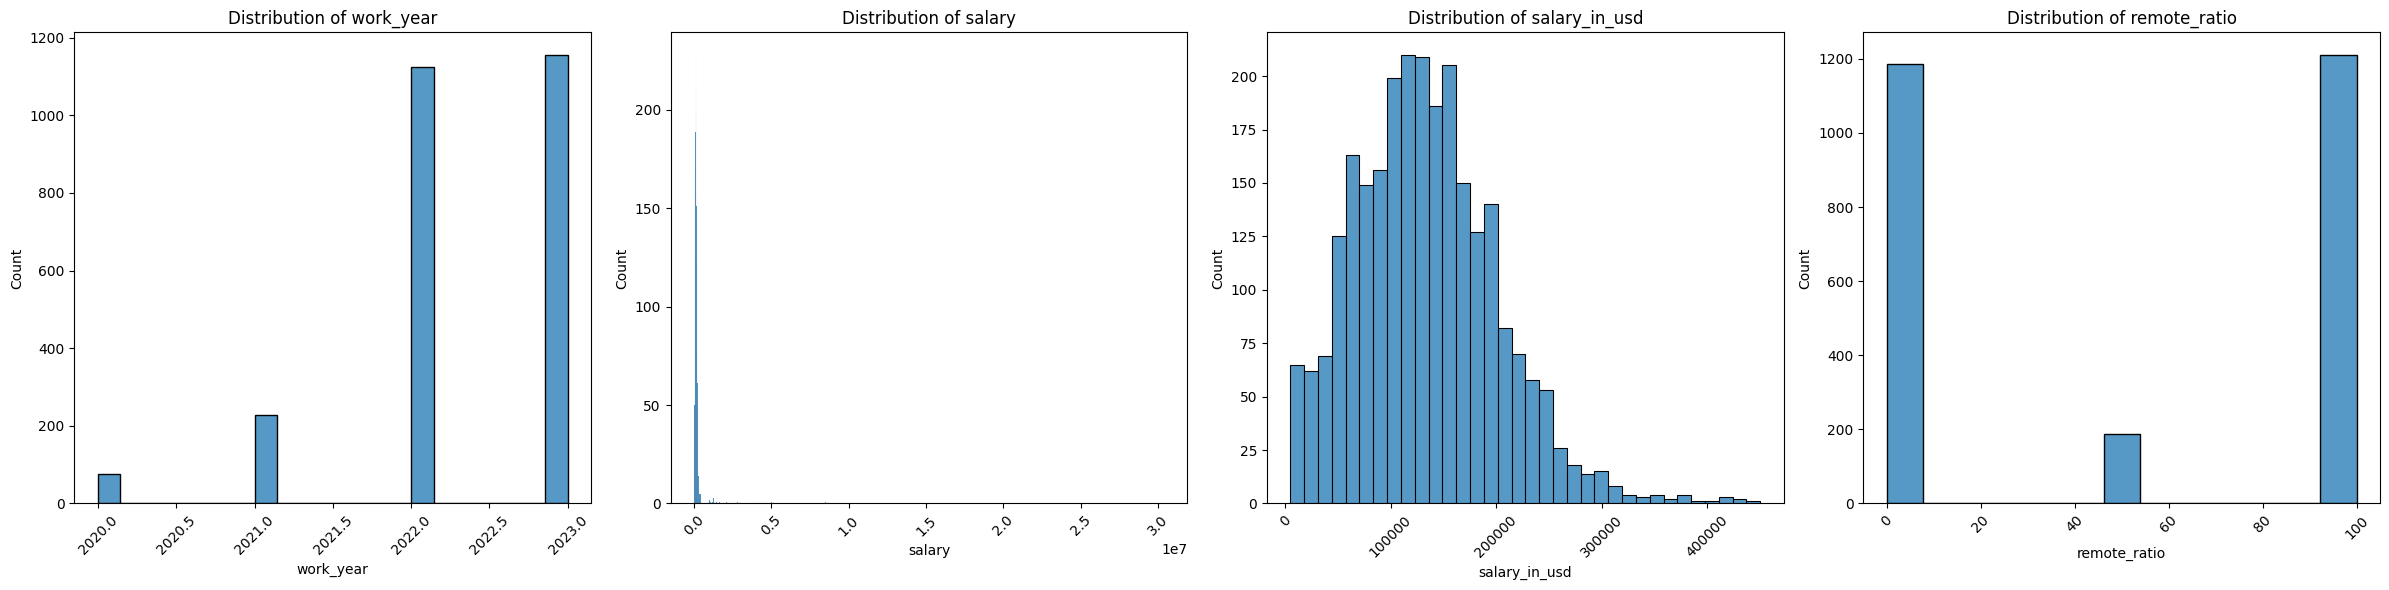

In [11]:
cols = ["work_year", "salary", "salary_in_usd", "remote_ratio"]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

experience_level: 4 valores √∫nicos
employment_type: 4 valores √∫nicos
job_title: 93 valores √∫nicos
salary_currency: 20 valores √∫nicos
employee_residence: 78 valores √∫nicos
company_location: 72 valores √∫nicos
company_size: 3 valores √∫nicos

Variables con alta cardinalidad (>10 valores): ['job_title', 'salary_currency', 'employee_residence', 'company_location']


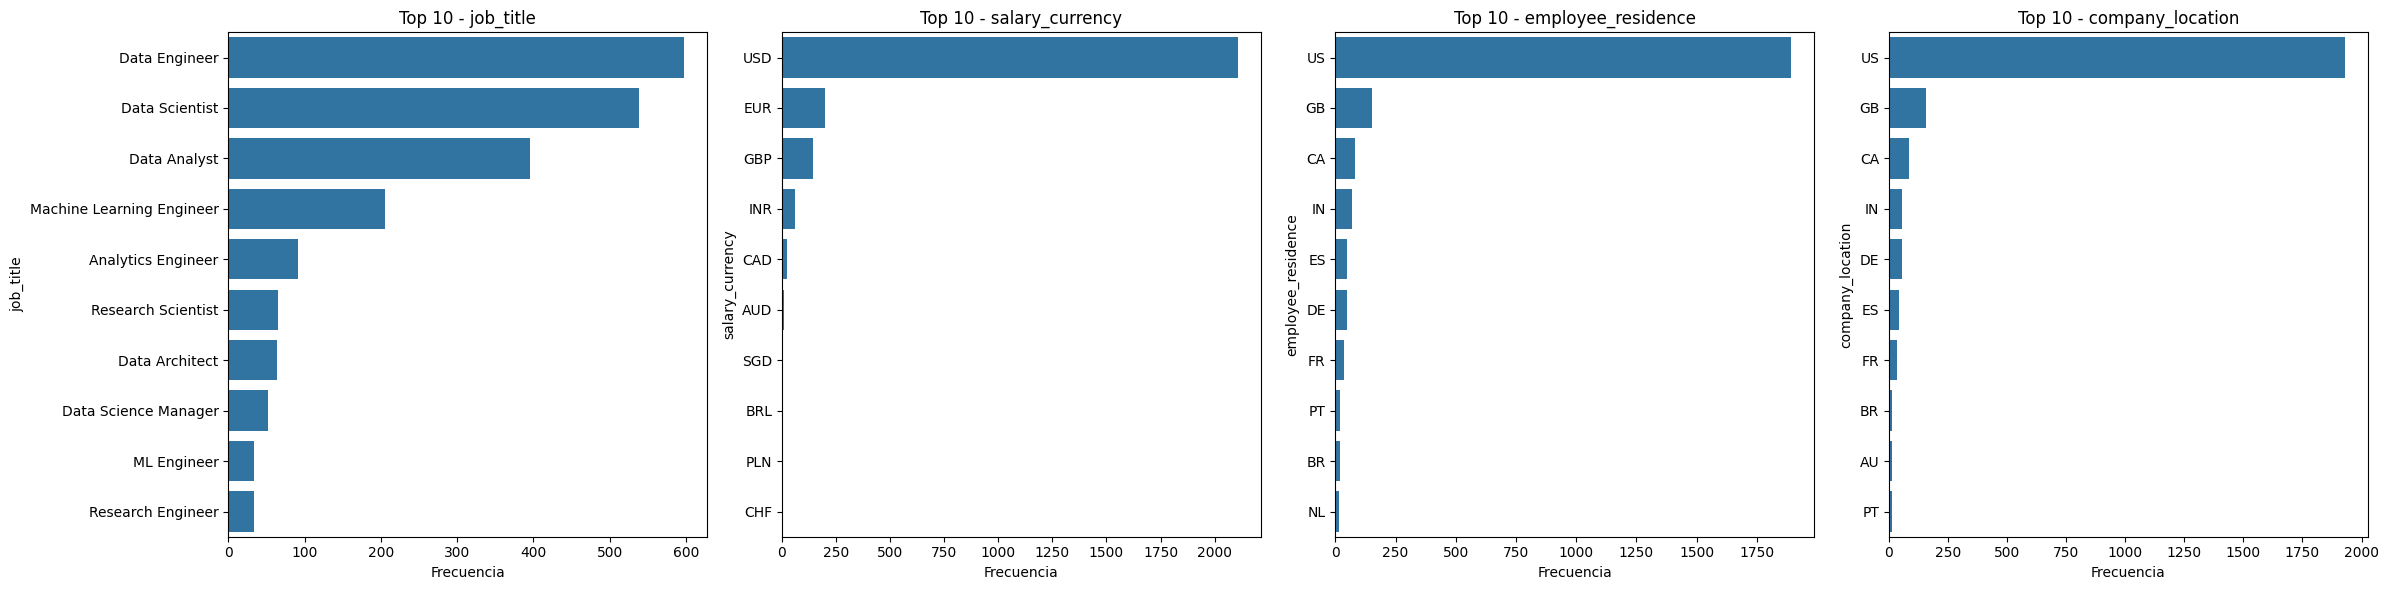

In [12]:
# Identificar variables categ√≥ricas con muchos valores √∫nicos
categorical_cols = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", "company_location", "company_size"]

# Verificar cu√°ntos valores √∫nicos tiene cada variable
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} valores √∫nicos")

# Variables con muchos valores √∫nicos (>10) - crear top 10
high_cardinality_cols = []
for col in categorical_cols:
    if df[col].nunique() > 10:
        high_cardinality_cols.append(col)

print(f"\nVariables con alta cardinalidad (>10 valores): {high_cardinality_cols}")

# Crear gr√°ficos de top 10 para variables con alta cardinalidad
if high_cardinality_cols:
    n_cols = len(high_cardinality_cols)
    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(6*n_cols, 6))
    
    if n_cols == 1:
        axes = [axes]
    
    for i, col in enumerate(high_cardinality_cols):
        top_10 = df[col].value_counts().head(10)
        sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i])
        axes[i].set_title(f'Top 10 - {col}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

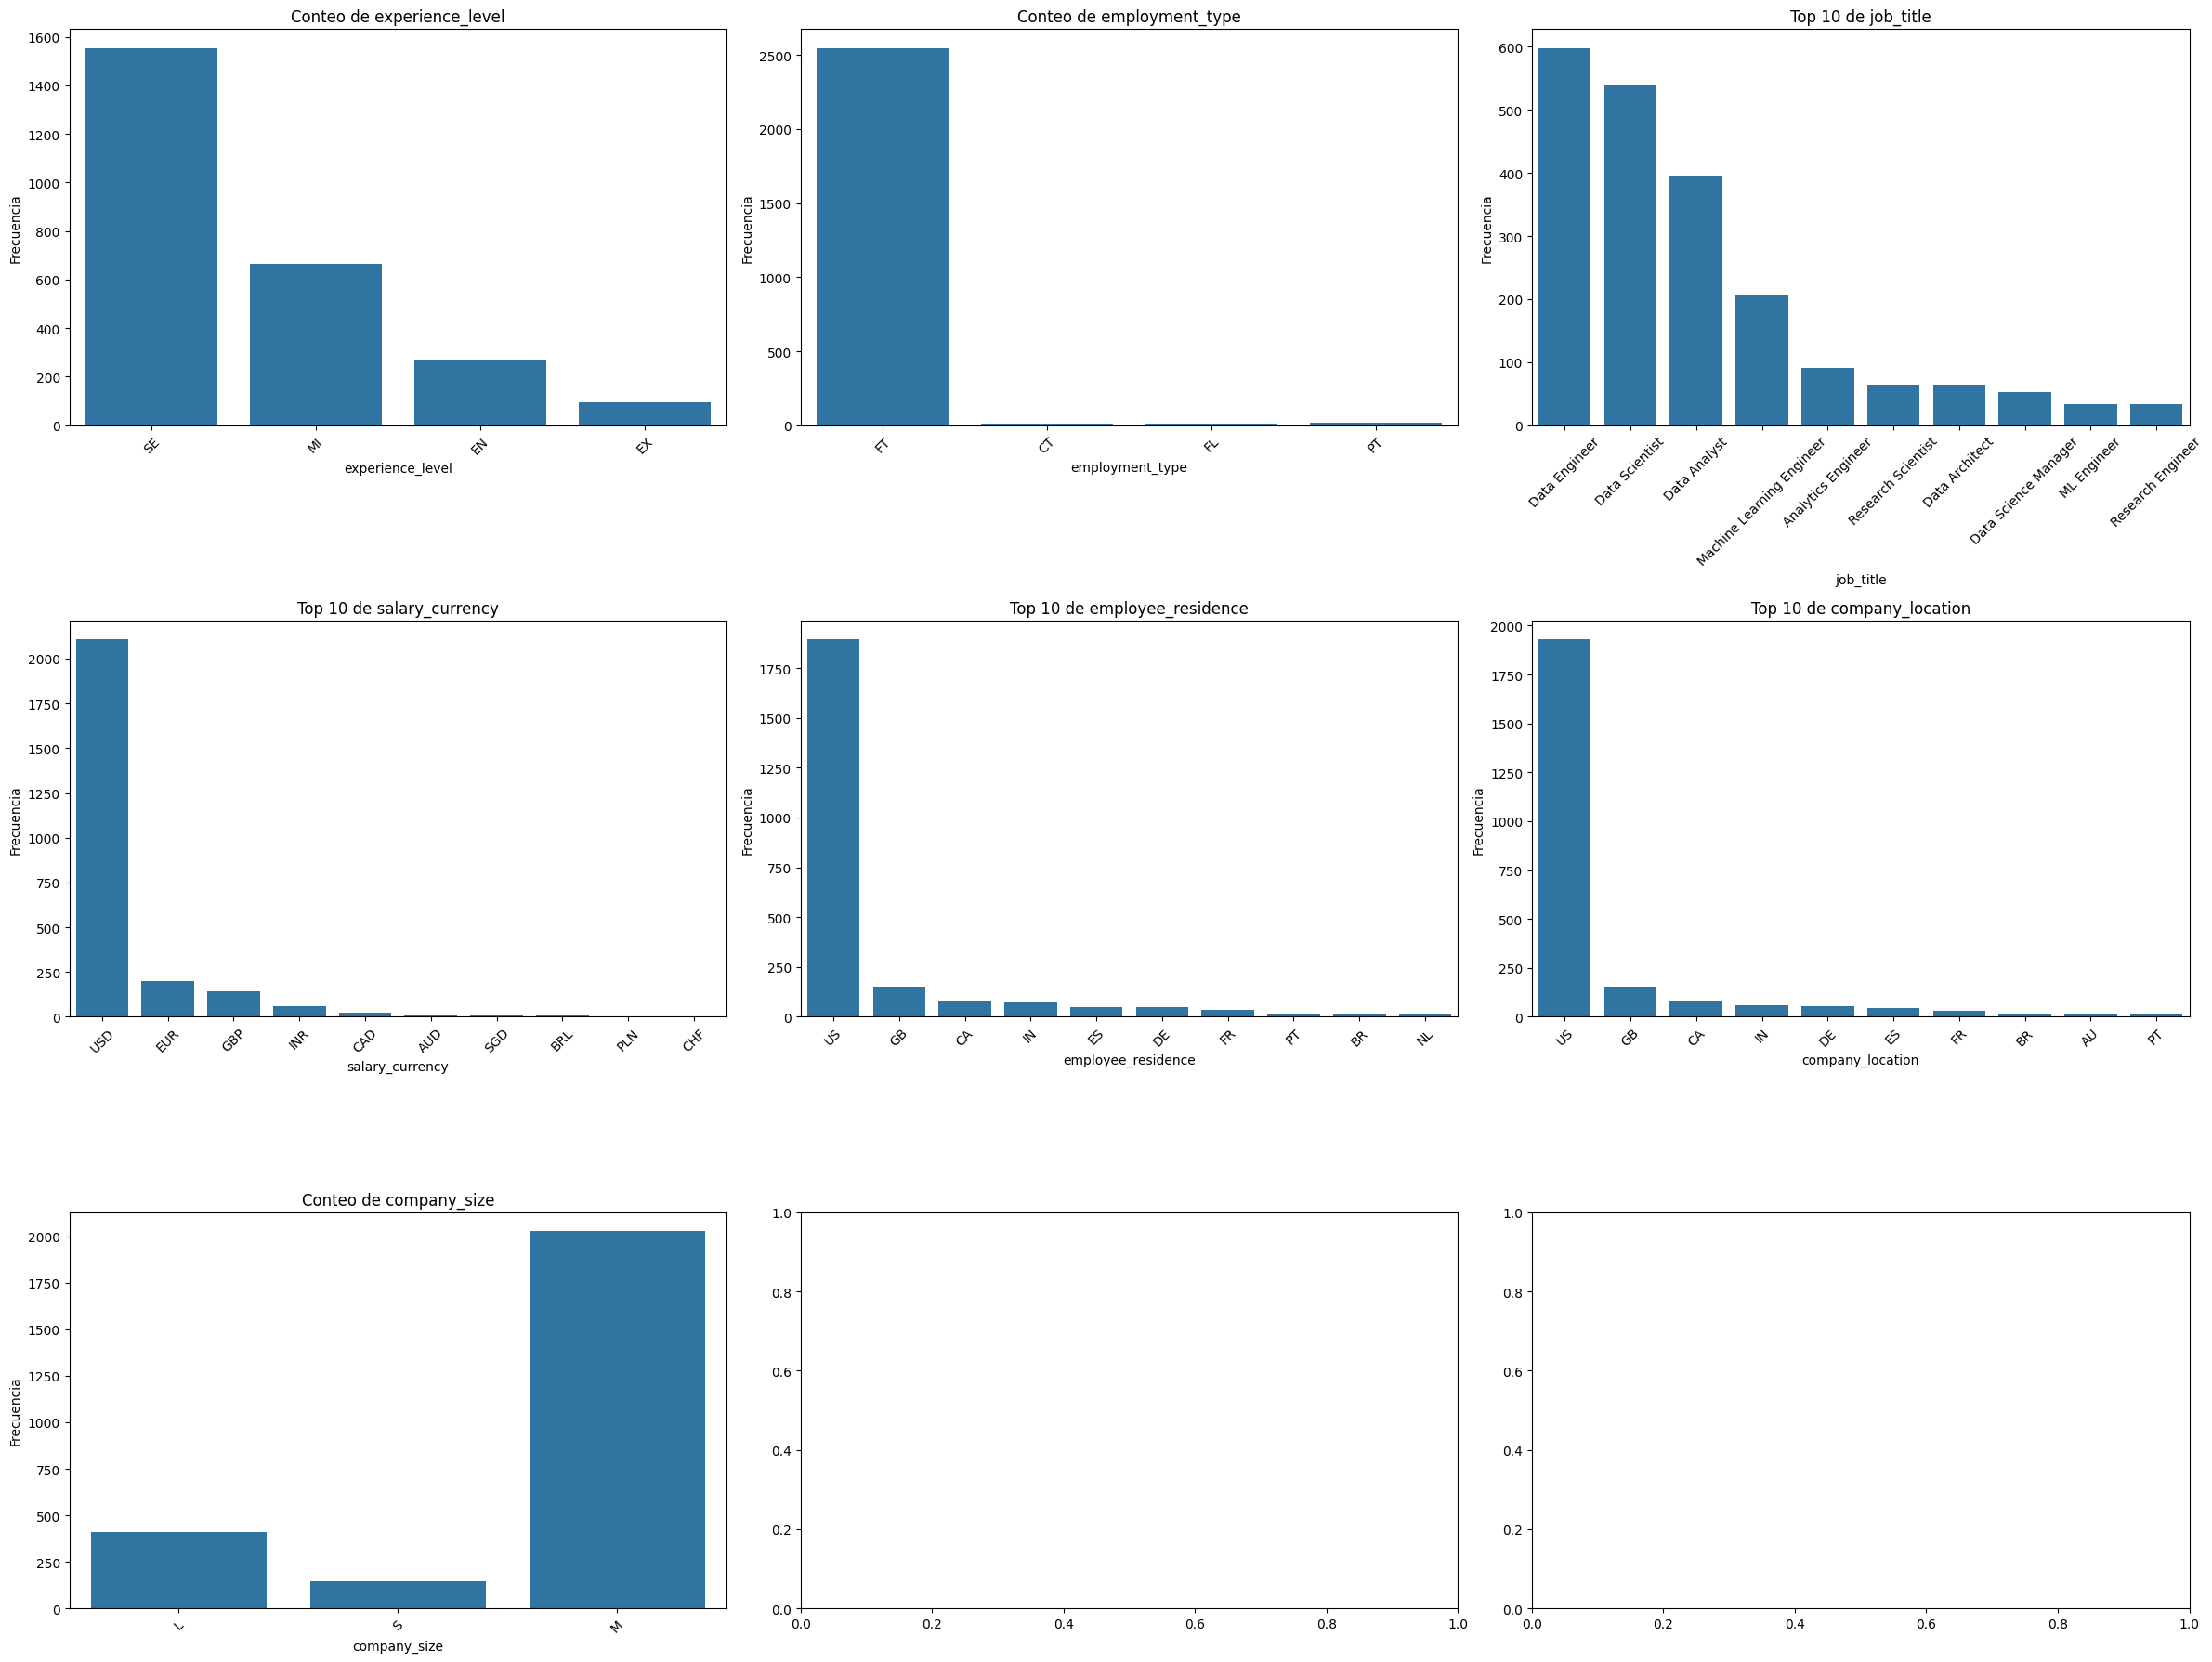

In [13]:
cols = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", "company_location", "company_size"]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for ax, col in zip(axes.flatten(), cols):
    n_unique = df[col].nunique()
    if n_unique > 15:  # Umbral para considerar "masiva"
        top10 = df[col].value_counts().nlargest(10)
        sns.barplot(x=top10.index, y=top10.values, ax=ax)
        ax.set_title(f'Top 10 de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)
    else:
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Conteo de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### T√©cnica 1: Boxplots e IQR (rango intercuart√≠lico)

- An√°lisis: evaluamos cada variable num√©rica de forma univariada para detectar valores alejados de la mediana y de los cuartiles.
- T√©cnica: el m√©todo IQR define l√≠mites t√≠picos: [Q1 ‚àí 1.5¬∑IQR, Q3 + 1.5¬∑IQR]. Valores fuera de ese rango son potenciales outliers.
- Explicaci√≥n: es robusto frente a distribuciones sesgadas y no asume normalidad; ideal como primer filtro.
- Resultados: boxplots por variable y conteo de observaciones fuera de los l√≠mites IQR; estos puntos deben revisarse (no eliminarse autom√°ticamente).
- Cu√°ndo usarlo: cuando queremos una detecci√≥n simple, interpretable y resistente a la asimetr√≠a de la distribuci√≥n.


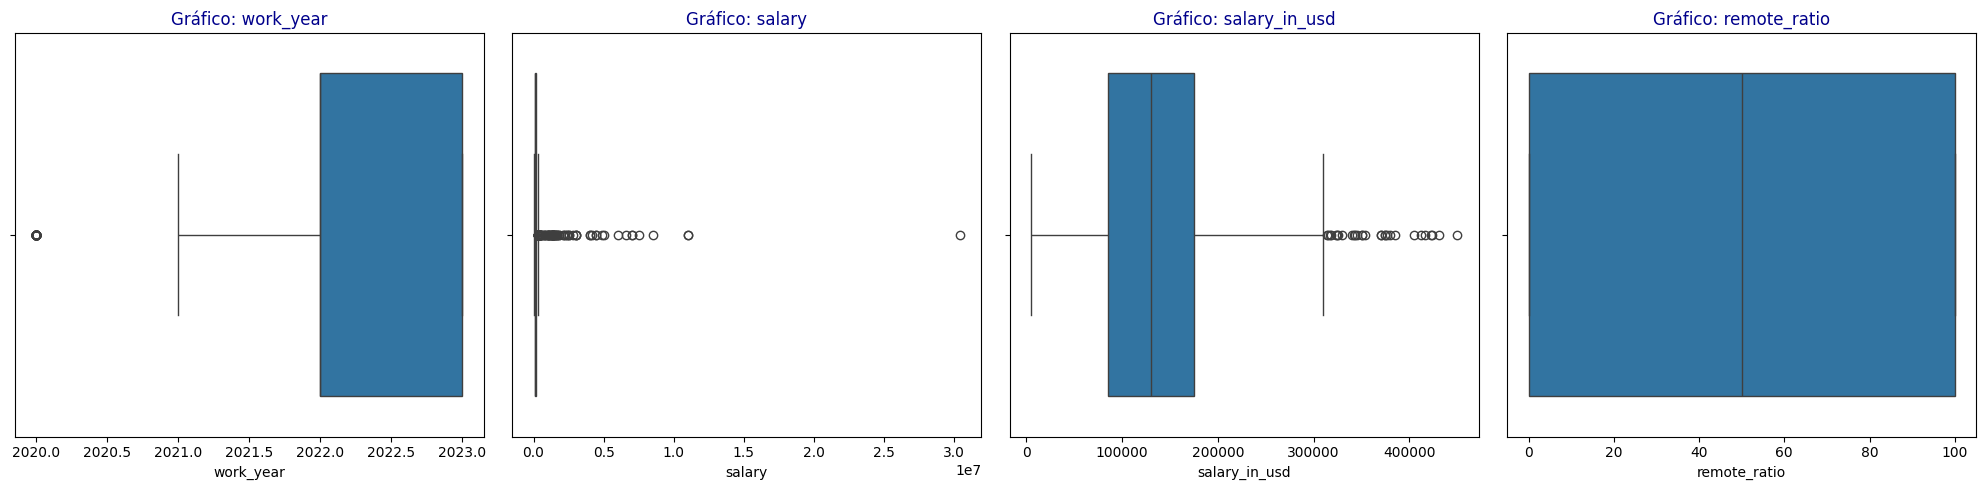

In [14]:
import math
def identificar_outliers(dataframe):
    """
    Esta funci√≥n crea un gr√°fico de caja (boxplot) para cada columna num√©rica 
    en un DataFrame para ayudar a identificar los outliers.
    """
    # Seleccionamos solo las columnas num√©ricas
    numeric_cols = dataframe.select_dtypes(include=np.number).columns

    # Creamos los subplots
    ncols = 4
    nrows = math.ceil(len(numeric_cols) / ncols) 
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows))

    # Si el dataframe tiene menos de 4 columnas num√©ricas, axes no ser√° una lista de listas, por lo que se convierte en una para poder iterar
    if nrows == 1 or ncols == 1:
        axes = [axes]

    for i, col in enumerate(numeric_cols):
        row = i // ncols
        col_idx = i % ncols
        # Comprueba si la columna tiene m√°s de un valor √∫nico para evitar errores
        if len(dataframe[col].unique()) > 1:
            sns.boxplot(x=dataframe[col], data=dataframe, ax=axes[row][col_idx])
            axes[row][col_idx].set_title(f"Gr√°fico: {col}", color="DarkBlue")
        else:
            print(f"La columna {col} tiene un solo valor √∫nico y no se puede graficar")

    plt.tight_layout()
    plt.show()

identificar_outliers(df)


### T√©cnica 2: Z-score (estandarizaci√≥n)

- An√°lisis: medimos cu√°ntos desv√≠os est√°ndar se aleja cada valor de la media en cada variable num√©rica.
- T√©cnica: calculamos el Z-score y marcamos como outliers los valores con |Z| > umbral (t√≠picamente 3.0).
- Explicaci√≥n: asume (aproximadamente) normalidad; es sensible a colas pesadas, por lo que conviene combinarlo con m√©todos robustos.
- Resultados: resumen por columna con cantidad/porcentaje de outliers y rangos extremos detectados.
- Cu√°ndo usarlo: cuando la variable es cercana a normal o queremos una regla simple y consistente para cribar valores extremos.


In [15]:
from scipy import stats

def identificar_outliers_zscore(dataframe, threshold=3):
    """
    Identifica outliers usando el m√©todo Z-score para columnas num√©ricas.
    
    Par√°metros:
    - dataframe: DataFrame de pandas
    - threshold: umbral del Z-score (por defecto 3, valores t√≠picos: 2.5-3.5)
    
    Retorna:
    - DataFrame con informaci√≥n de outliers por columna
    - Diccionario con √≠ndices de outliers por columna
    """
    
    # Seleccionar solo columnas num√©ricas
    numeric_cols = dataframe.select_dtypes(include=np.number).columns
    
    outliers_info = {}
    outliers_indices = {}
    
    print(f"Identificando outliers con Z-score > {threshold}\n")
    print("="*60)
    
    for col in numeric_cols:
        # Calcular Z-score
        z_scores = np.abs(stats.zscore(dataframe[col]))
        
        # Identificar outliers
        outlier_mask = z_scores > threshold
        outlier_indices = dataframe[outlier_mask].index.tolist()
        
        # Guardar informaci√≥n
        outliers_indices[col] = outlier_indices
        outliers_info[col] = {
            'total_outliers': len(outlier_indices),
            'percentage': (len(outlier_indices) / len(dataframe)) * 100,
            'min_outlier': dataframe.loc[outlier_indices, col].min() if outlier_indices else None,
            'max_outlier': dataframe.loc[outlier_indices, col].max() if outlier_indices else None,
            'outlier_indices': outlier_indices[:10]  # Mostrar solo los primeros 10
        }
        
        # Imprimir resumen
        print(f"Columna: {col}")
        print(f"  - Outliers encontrados: {outliers_info[col]['total_outliers']}")
        print(f"  - Porcentaje: {outliers_info[col]['percentage']:.2f}%")
        if outlier_indices:
            print(f"  - Rango outliers: [{outliers_info[col]['min_outlier']:.0f} - {outliers_info[col]['max_outlier']:.0f}]")
            print(f"  - Primeros √≠ndices: {outliers_info[col]['outlier_indices']}")
        print("-" * 40)
    
    return outliers_info, outliers_indices

# Ejecutar la funci√≥n
outliers_info, outliers_indices = identificar_outliers_zscore(df, threshold=3)

Identificando outliers con Z-score > 3

Columna: work_year
  - Outliers encontrados: 75
  - Porcentaje: 2.90%
  - Rango outliers: [2020 - 2020]
  - Primeros √≠ndices: [183, 2118, 3119, 3138, 3163, 3419, 3446, 3455, 3506, 3514]
----------------------------------------
Columna: salary
  - Outliers encontrados: 20
  - Porcentaje: 0.77%
  - Rango outliers: [2800000 - 30400000]
  - Primeros √≠ndices: [1462, 1738, 1868, 1946, 2358, 2655, 2966, 3061, 3192, 3475]
----------------------------------------
Columna: salary_in_usd
  - Outliers encontrados: 21
  - Porcentaje: 0.81%
  - Rango outliers: [340000 - 450000]
  - Primeros √≠ndices: [33, 133, 478, 528, 649, 845, 1105, 1258, 1288, 1311]
----------------------------------------
Columna: remote_ratio
  - Outliers encontrados: 0
  - Porcentaje: 0.00%
----------------------------------------


### T√©cnica 3: Isolation Forest (multivariante)

- An√°lisis: identificamos observaciones an√≥malas considerando conjuntamente todas las variables num√©ricas.
- T√©cnica: Isolation Forest a√≠sla outliers a trav√©s de particiones aleatorias; los casos m√°s f√°ciles de aislar (menos particiones) son marcados como anomal√≠as.
- Explicaci√≥n: no asume distribuci√≥n, captura relaciones entre variables y funciona bien con colas pesadas o estructuras complejas.
- Resultados: columna `outlier_flag` (-1 outlier, 1 normal), `anomaly_score` (m√°s negativo, m√°s an√≥malo) y resumen de estad√≠sticas por variable en outliers vs. normales.
- Cu√°ndo usarlo: cuando sospechamos outliers multivariantes o cuando los m√©todos univariantes no capturan bien anomal√≠as combinadas.

In [16]:
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings('ignore')

def analisis_outliers_isolation_forest(dataframe, contamination=0.1, random_state=42):
    """
    Detecta outliers usando Isolation Forest en variables num√©ricas del dataset.
    
    ¬øQu√© es Isolation Forest?
    - Algoritmo no supervisado que detecta anomal√≠as aislando observaciones
    - Principio: outliers son m√°s f√°ciles de aislar (requieren menos "cortes" en el √°rbol)
    - Ventaja sobre Z-score: no asume distribuci√≥n normal, maneja relaciones multivariadas
    
    Par√°metros:
    - dataframe: DataFrame de pandas con los datos
    - contamination: proporci√≥n esperada de outliers (0.1 = 10% de los datos)
    - random_state: semilla para reproducibilidad
    
    Retorna:
    - DataFrame original con columna 'outlier_flag' (-1 = outlier, 1 = normal)
    - Diccionario con estad√≠sticas y an√°lisis detallado
    """
    
    # 1. PREPARACI√ìN DE DATOS
    # Seleccionar solo columnas num√©ricas para el an√°lisis
    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()
    print(f"üîç Analizando outliers en columnas num√©ricas: {numeric_cols}")
    print(f"üìä Configuraci√≥n: {contamination*100}% de datos esperados como outliers")
    print("="*70)
    
    # Crear copia del dataframe para no modificar el original
    df_analysis = dataframe[numeric_cols].copy()
    
    # 2. APLICACI√ìN DEL ISOLATION FOREST
    # Configurar el modelo
    iso_forest = IsolationForest(
        contamination=contamination,  # Proporci√≥n esperada de outliers
        random_state=random_state,    # Para reproducibilidad
        n_estimators=100             # N√∫mero de √°rboles (m√°s √°rboles = m√°s estable)
    )
    
    # Entrenar el modelo y predecir outliers
    # Resultado: 1 = normal, -1 = outlier
    outlier_predictions = iso_forest.fit_predict(df_analysis)
    
    # Obtener scores de anomal√≠a (valores m√°s negativos = m√°s an√≥malos)
    anomaly_scores = iso_forest.decision_function(df_analysis)
    
    # 3. AN√ÅLISIS DE RESULTADOS
    # Agregar resultados al dataframe original
    df_result = dataframe.copy()
    df_result['outlier_flag'] = outlier_predictions
    df_result['anomaly_score'] = anomaly_scores
    
    # Calcular estad√≠sticas generales
    total_outliers = np.sum(outlier_predictions == -1)
    total_normal = np.sum(outlier_predictions == 1)
    outlier_percentage = (total_outliers / len(dataframe)) * 100
    
    print(f"üìà RESULTADOS GENERALES:")
    print(f"   ‚Ä¢ Total de registros: {len(dataframe)}")
    print(f"   ‚Ä¢ Outliers detectados: {total_outliers} ({outlier_percentage:.2f}%)")
    print(f"   ‚Ä¢ Registros normales: {total_normal} ({100-outlier_percentage:.2f}%)")
    print("\n" + "="*70)
    
    # 4. AN√ÅLISIS DETALLADO POR VARIABLE
    print(f"üìä AN√ÅLISIS POR VARIABLE (outliers vs normales):")
    print("-"*70)
    
    outliers_df = df_result[df_result['outlier_flag'] == -1]
    normal_df = df_result[df_result['outlier_flag'] == 1]
    
    analysis_results = {}
    
    for col in numeric_cols:
        # Estad√≠sticas para outliers y normales
        outlier_stats = {
            'mean': outliers_df[col].mean(),
            'median': outliers_df[col].median(),
            'std': outliers_df[col].std(),
            'min': outliers_df[col].min(),
            'max': outliers_df[col].max()
        }
        
        normal_stats = {
            'mean': normal_df[col].mean(),
            'median': normal_df[col].median(), 
            'std': normal_df[col].std(),
            'min': normal_df[col].min(),
            'max': normal_df[col].max()
        }
        
        analysis_results[col] = {
            'outlier_stats': outlier_stats,
            'normal_stats': normal_stats
        }
        
        print(f"\nüî∏ {col.upper()}:")
        print(f"   Outliers  - Media: {outlier_stats['mean']:>10,.0f} | Mediana: {outlier_stats['median']:>10,.0f} | Rango: [{outlier_stats['min']:,.0f} - {outlier_stats['max']:,.0f}]")
        print(f"   Normales  - Media: {normal_stats['mean']:>10,.0f} | Mediana: {normal_stats['median']:>10,.0f} | Rango: [{normal_stats['min']:,.0f} - {normal_stats['max']:,.0f}]")
    
    # 5. IDENTIFICAR CASOS M√ÅS EXTREMOS
    print(f"\n" + "="*70)
    print(f"üö® TOP 10 OUTLIERS M√ÅS EXTREMOS (menor anomaly_score):")
    print("-"*70)
    
    top_outliers = df_result[df_result['outlier_flag'] == -1].nsmallest(10, 'anomaly_score')
    
    for idx, (index, row) in enumerate(top_outliers.iterrows(), 1):
        print(f"{idx:2d}. √çndice {index} | Score: {row['anomaly_score']:.3f}")
        for col in numeric_cols:
            print(f"      {col}: {row[col]:,}")
        print()
    
    # 6. PREPARAR DICCIONARIO DE RETORNO
    summary_dict = {
        'total_records': len(dataframe),
        'total_outliers': total_outliers,
        'outlier_percentage': outlier_percentage,
        'contamination_used': contamination,
        'numeric_columns_analyzed': numeric_cols,
        'outlier_indices': df_result[df_result['outlier_flag'] == -1].index.tolist(),
        'top_outliers_indices': top_outliers.index.tolist(),
        'variable_analysis': analysis_results,
        'model_params': {
            'contamination': contamination,
            'random_state': random_state,
            'n_estimators': 100
        }
    }
    
    return df_result, summary_dict

# EJECUTAR EL AN√ÅLISIS
print("üîç AN√ÅLISIS DE OUTLIERS CON ISOLATION FOREST")
print("="*70)
print("‚ÑπÔ∏è  Isolation Forest es especialmente √∫til para:")
print("   ‚Ä¢ Detectar outliers multivariados (considera relaciones entre variables)")
print("   ‚Ä¢ Datasets sin distribuci√≥n normal conocida")
print("   ‚Ä¢ Casos donde outliers son minor√≠a pero impactan an√°lisis")
print("\n")

# Aplicar an√°lisis con 10% de contaminaci√≥n esperada
df_con_outliers, resultados_isolation = analisis_outliers_isolation_forest(
    df, 
    contamination=0.1,  # Esperamos ~10% de outliers
    random_state=42
)

print("\n" + "="*70)
print("‚úÖ AN√ÅLISIS COMPLETADO")
print(f"üìÅ Variable 'df_con_outliers' creada con columnas:")
print(f"   ‚Ä¢ 'outlier_flag': -1 = outlier, 1 = normal")
print(f"   ‚Ä¢ 'anomaly_score': score de anomal√≠a (m√°s negativo = m√°s an√≥malo)")
print(f"üìä Diccionario 'resultados_isolation' contiene estad√≠sticas completas")

üîç AN√ÅLISIS DE OUTLIERS CON ISOLATION FOREST
‚ÑπÔ∏è  Isolation Forest es especialmente √∫til para:
   ‚Ä¢ Detectar outliers multivariados (considera relaciones entre variables)
   ‚Ä¢ Datasets sin distribuci√≥n normal conocida
   ‚Ä¢ Casos donde outliers son minor√≠a pero impactan an√°lisis


üîç Analizando outliers en columnas num√©ricas: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
üìä Configuraci√≥n: 10.0% de datos esperados como outliers
üìà RESULTADOS GENERALES:
   ‚Ä¢ Total de registros: 2584
   ‚Ä¢ Outliers detectados: 259 (10.02%)
   ‚Ä¢ Registros normales: 2325 (89.98%)

üìä AN√ÅLISIS POR VARIABLE (outliers vs normales):
----------------------------------------------------------------------

üî∏ WORK_YEAR:
   Outliers  - Media:      2,021 | Mediana:      2,021 | Rango: [2,020 - 2,023]
   Normales  - Media:      2,022 | Mediana:      2,022 | Rango: [2,021 - 2,023]

üî∏ SALARY:
   Outliers  - Media:    901,949 | Mediana:    280,100 | Rango: [6,000 - 30,400,0

### Cual es el salario promedio por nivel de experiencia?

In [17]:
### Cual es el salario promedio por nivel de experiencia?
salario_promedio_experiencia = df.groupby('experience_level')['salary_in_usd'].mean().reset_index()
salario_promedio_experiencia = salario_promedio_experiencia.sort_values(by='salary_in_usd', ascending=False)
salario_promedio_experiencia

experience_level  salary_in_usd
1               EX  191078.208333
3               SE  153897.435650
2               MI  101828.783133
0               EN   72648.685185

In [18]:
# graficamos el salario promedio por nivel de experiencia con plotly
fig = px.bar(salario_promedio_experiencia, 
             x='experience_level', 
             y='salary_in_usd',
             title='Salario Promedio por Nivel de Experiencia',
             labels={'experience_level': 'Nivel de Experiencia', 
                     'salary_in_usd': 'Salario Promedio (USD)'},
             color='salary_in_usd',
             color_continuous_scale='viridis')

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    showlegend=False
)

fig.show()

## Preguntas de EDA avanzadas

> A continuaci√≥n se proponen 9 preguntas anal√≠ticas para profundizar el EDA. Cada pregunta incluye un objetivo y un ejemplo de c√≥digo reproducible sobre `df` para obtener respuestas iniciales. Ajusta filtros y visualizaciones seg√∫n tus hip√≥tesis.

1) ¬øC√≥mo var√≠a la mediana salarial por t√≠tulo y nivel de experiencia?
Objetivo: identificar combinaciones `job_title` √ó `experience_level` mejor remuneradas y con mayor consistencia.

2) ¬øExiste una ‚Äúprima remoto‚Äù (remote premium) y cambia por seniority?
Objetivo: cuantificar diferencias salariales entre `on-site`, `hybrid`, `remote` y entender si crecen con la experiencia.

3) ¬øHay prima transfronteriza? (empleado y empresa en pa√≠ses distintos)
Objetivo: medir el diferencial salarial cuando `employee_residence != company_location` y si depende del nivel de experiencia.

4) ¬øQu√© tendencia temporal muestra el salario por nivel?
Objetivo: evaluar si las medianas han crecido o no por `work_year` y `experience_level`.

5) ¬øC√≥mo impacta el tama√±o de empresa en el salario por seniority?
Objetivo: comparar `company_size` (S/M/L) dentro de cada `experience_level`.

6) ¬øQu√© mercados (pa√≠ses) concentran mayor talento y mejores salarios?
Objetivo: listar top pa√≠ses por volumen (`count`) e incluir mediana y p90 de `salary_in_usd`.

7) ¬øD√≥nde se concentran los outliers salariales?
Objetivo: ubicar grupos (por `job_title`, `company_location`, etc.) con mayores tasas de outliers y revisar causas.

8) ¬øQu√© roles tienen mayor dispersi√≥n salarial interna?
Objetivo: priorizar roles con alta varianza/IQR para segmentar (subfamilias, tecnolog√≠as, industria).

9) ¬øQu√© t√≠tulos muestran mayor crecimiento salarial en el tiempo?
Objetivo: detectar roles en ascenso (crecimiento de mediana entre a√±os).

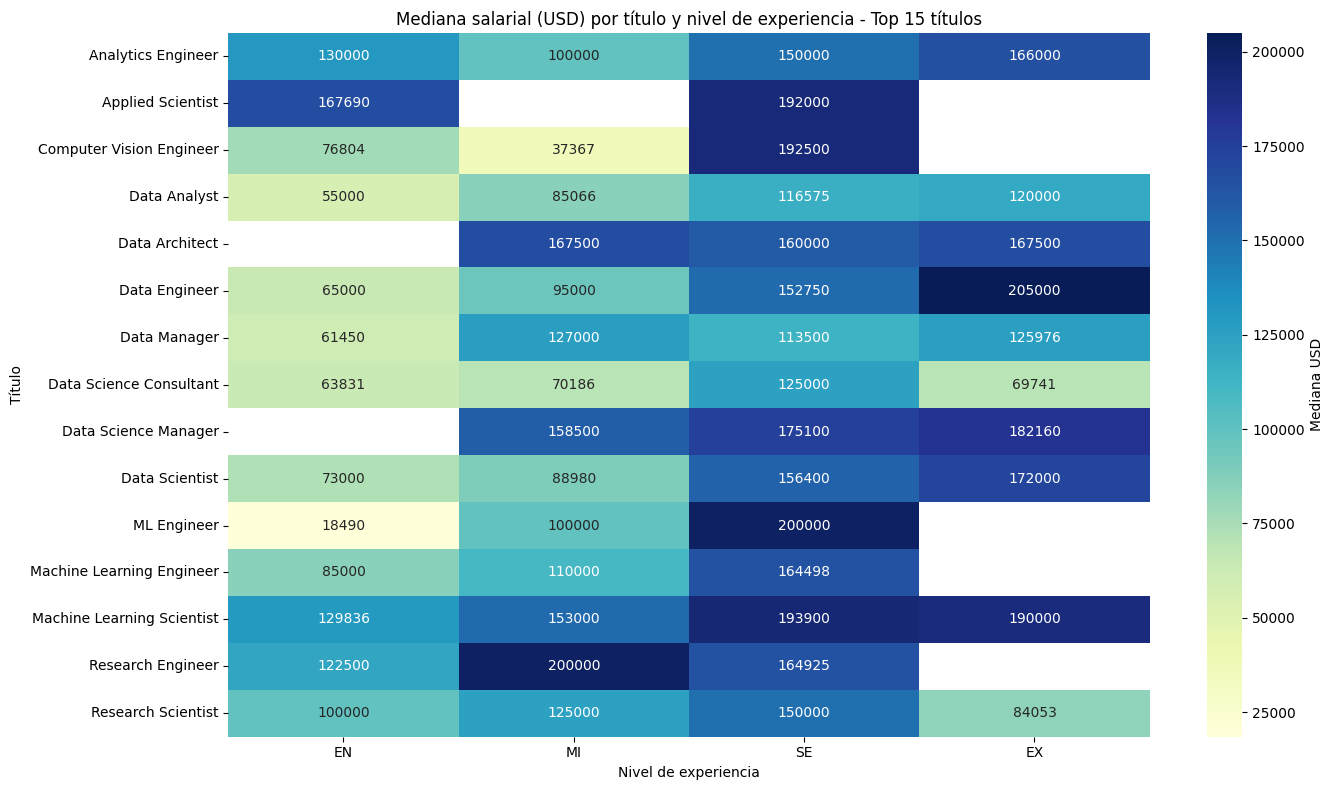

In [19]:
# Pregunta 1) ¬øC√≥mo var√≠a la mediana salarial por t√≠tulo y nivel de experiencia?
## Objetivo: identificar combinaciones job_title √ó experience_level mejor remuneradas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tomamos los 15 t√≠tulos con m√°s registros para una vista manejable
top_titles = df['job_title'].value_counts().nlargest(15).index.tolist()
df_top = df[df['job_title'].isin(top_titles)].copy()

# Orden l√≥gico de niveles si existen
level_order = ['EN','MI','SE','EX']
if set(level_order).issubset(set(df_top['experience_level'].unique())):
    df_top['experience_level'] = pd.Categorical(df_top['experience_level'], categories=level_order, ordered=True)

# Tabla din√°mica de medianas
pivot_med = (df_top
               .groupby(['job_title','experience_level'])['salary_in_usd']
               .median()
               .unstack(fill_value=np.nan))

plt.figure(figsize=(14,8))
sns.heatmap(pivot_med, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label':'Mediana USD'})
plt.title('Mediana salarial (USD) por t√≠tulo y nivel de experiencia - Top 15 t√≠tulos')
plt.xlabel('Nivel de experiencia')
plt.ylabel('T√≠tulo')
plt.tight_layout()
plt.show()

### Pregunta 2) ¬øExiste una ‚Äúprima remoto‚Äù y cambia por seniority?
Objetivo: cuantificar diferencias salariales entre `on-site`, `hybrid`, `remote` y si crecen con la experiencia.

Mediana (USD) por modalidad de trabajo:
 remote_label
on-site    137500.0
remote     130000.0
hybrid      63312.0
Name: salary_in_usd, dtype: float64


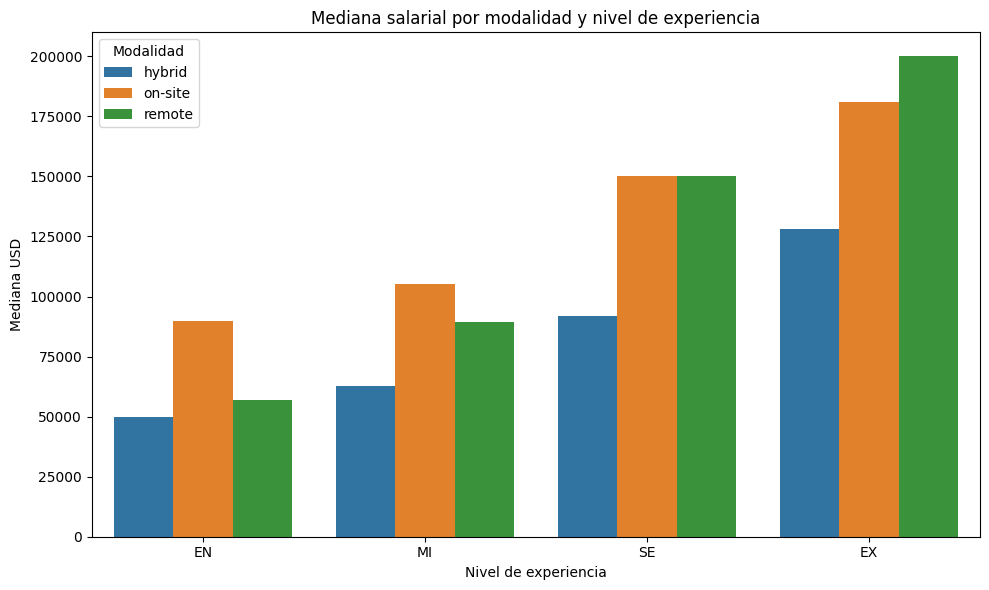

In [20]:
# Mapear remote_ratio a etiquetas
ratio_map = {0: 'on-site', 50: 'hybrid', 100: 'remote'}
df['remote_label'] = df['remote_ratio'].map(ratio_map).fillna('other')

# Mediana global por modalidad
med_global = df.groupby('remote_label')['salary_in_usd'].median().sort_values(ascending=False)
print('Mediana (USD) por modalidad de trabajo:\n', med_global)

# Mediana por modalidad y nivel de experiencia
level_order = ['EN','MI','SE','EX']
df['experience_level'] = pd.Categorical(df['experience_level'], categories=level_order, ordered=True)
med_por_nivel = (df.groupby(['experience_level','remote_label'])['salary_in_usd']
                    .median()
                    .reset_index())

plt.figure(figsize=(10,6))
sns.barplot(data=med_por_nivel, x='experience_level', y='salary_in_usd', hue='remote_label')
plt.title('Mediana salarial por modalidad y nivel de experiencia')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Mediana USD')
plt.legend(title='Modalidad')
plt.tight_layout()
plt.show()

### Pregunta 3) ¬øHay prima transfronteriza?
Objetivo: medir el diferencial cuando `employee_residence != company_location` y si var√≠a por nivel de experiencia.

Mediana (USD) cross-border vs same-country:
 cross_border
same-country    130000.0
cross-border     55108.5
Name: salary_in_usd, dtype: float64


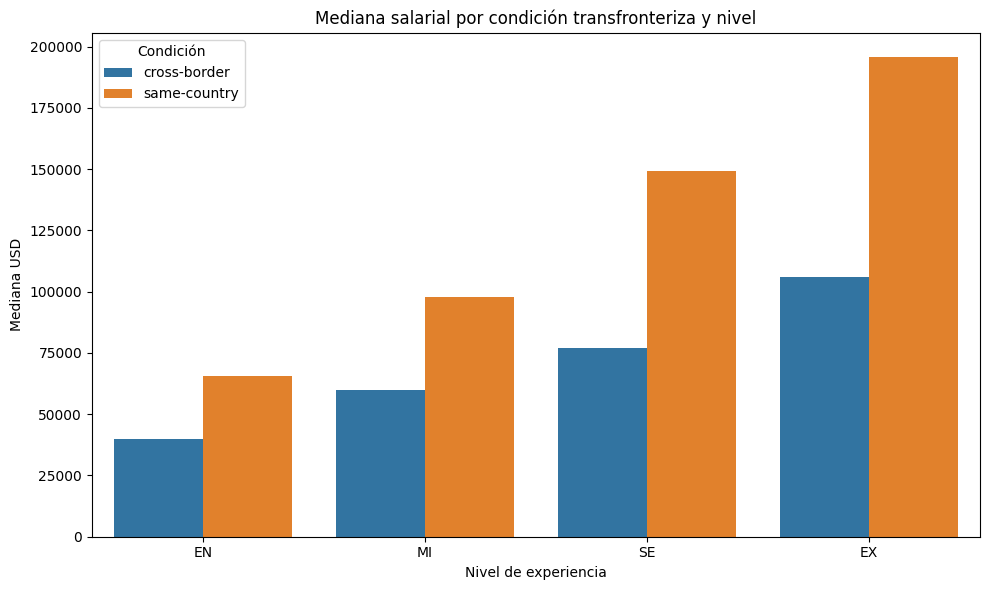

In [21]:
# Flag transfronterizo
df['cross_border'] = np.where(df['employee_residence'] != df['company_location'], 'cross-border', 'same-country')

# Mediana global
med_cb_global = df.groupby('cross_border')['salary_in_usd'].median().sort_values(ascending=False)
print('Mediana (USD) cross-border vs same-country:\n', med_cb_global)

# Mediana por nivel de experiencia
med_cb_nivel = (df.groupby(['experience_level','cross_border'])['salary_in_usd']
                    .median()
                    .reset_index())

plt.figure(figsize=(10,6))
sns.barplot(data=med_cb_nivel, x='experience_level', y='salary_in_usd', hue='cross_border')
plt.title('Mediana salarial por condici√≥n transfronteriza y nivel')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Mediana USD')
plt.legend(title='Condici√≥n')
plt.tight_layout()
plt.show()

### Pregunta 4) ¬øQu√© tendencia temporal muestra el salario por nivel?
Objetivo: evaluar crecimiento/estancamiento por a√±o y seniority.

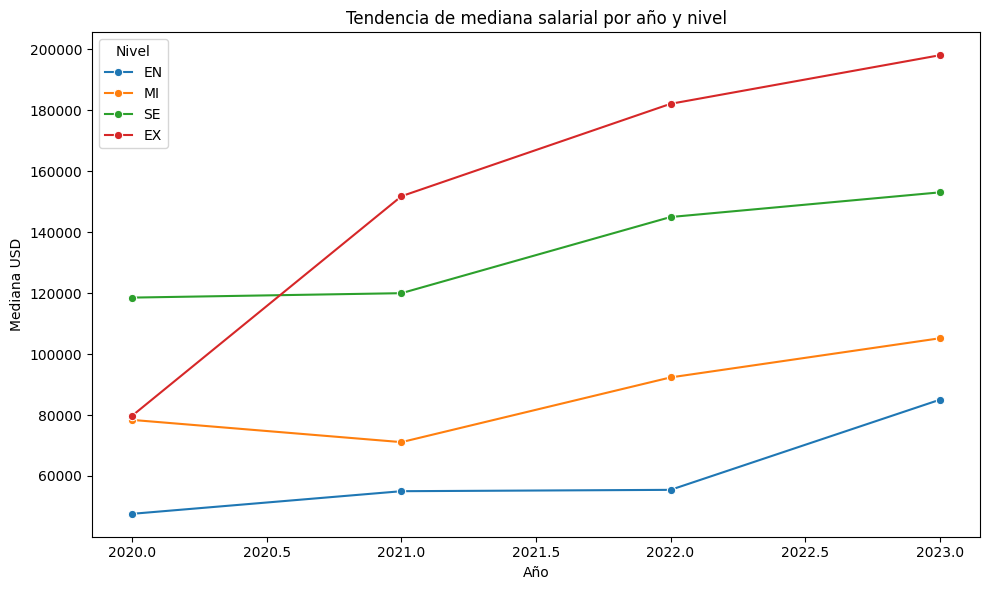

In [22]:
# Mediana por a√±o y nivel
trend = (df.groupby(['work_year','experience_level'])['salary_in_usd']
           .median()
           .reset_index())

plt.figure(figsize=(10,6))
sns.lineplot(data=trend, x='work_year', y='salary_in_usd', hue='experience_level', marker='o')
plt.title('Tendencia de mediana salarial por a√±o y nivel')
plt.xlabel('A√±o')
plt.ylabel('Mediana USD')
plt.legend(title='Nivel')
plt.tight_layout()
plt.show()

### Pregunta 5) ¬øC√≥mo impacta el tama√±o de empresa en el salario por seniority?
Objetivo: comparar `company_size` (S/M/L) dentro de cada `experience_level`.

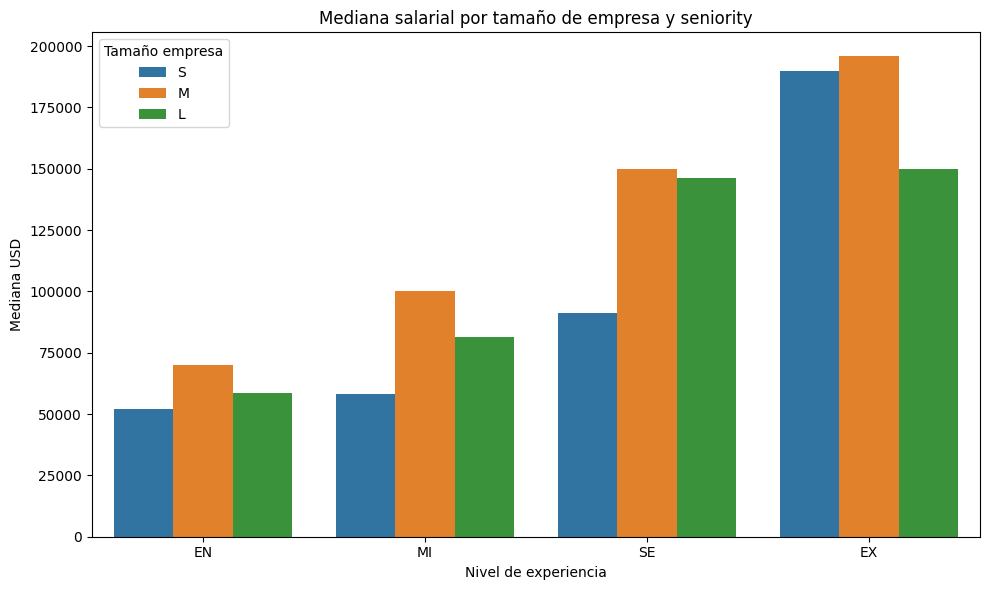

In [23]:
# Mediana por tama√±o de empresa y nivel
size_order = ['S','M','L']
df['company_size'] = pd.Categorical(df['company_size'], categories=size_order, ordered=True)
med_size = (df.groupby(['experience_level','company_size'])['salary_in_usd']
              .median()
              .reset_index())

plt.figure(figsize=(10,6))
sns.barplot(data=med_size, x='experience_level', y='salary_in_usd', hue='company_size')
plt.title('Mediana salarial por tama√±o de empresa y seniority')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Mediana USD')
plt.legend(title='Tama√±o empresa')
plt.tight_layout()
plt.show()

### Pregunta 6) ¬øQu√© mercados concentran m√°s talento y mejores salarios?
Objetivo: top pa√≠ses por volumen con mediana y p90 de `salary_in_usd`.

  company_location  count  median_usd   p90_usd
9               US   1929    145885.0  230000.0
6               GB    155     80036.0  127874.4
2               CA     83    120000.0  223000.0
7               IN     57     18314.0   58351.8
3               DE     55     71897.0  166456.8
4               ES     44     48289.0   82837.1
5               FR     33     59102.0  106860.4
1               BR     15     42000.0   78000.0
0               AU     14     72525.0  145129.8
8               PT     14     52932.5   72407.5


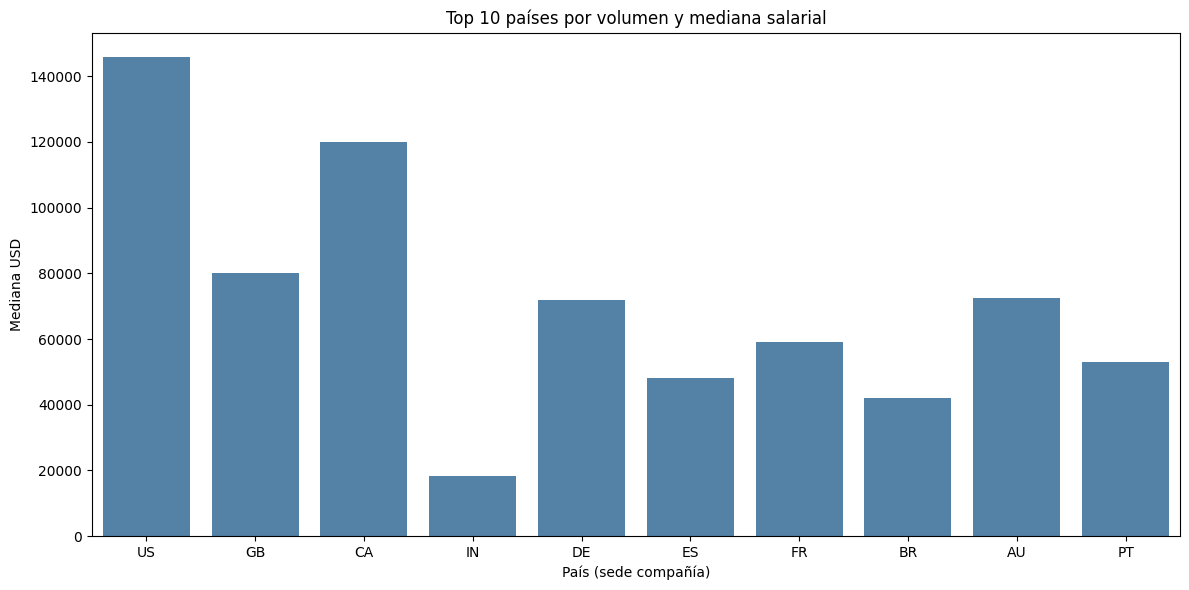

In [24]:
# Top 10 pa√≠ses por volumen y sus m√©tricas salariales
top_countries = df['company_location'].value_counts().nlargest(10).index.tolist()
geo = (df[df['company_location'].isin(top_countries)]
         .groupby('company_location')
         .agg(count=('salary_in_usd','size'),
              median_usd=('salary_in_usd','median'),
              p90_usd=('salary_in_usd', lambda x: np.percentile(x, 90)))
         .reset_index()
         .sort_values('count', ascending=False))
print(geo)

plt.figure(figsize=(12,6))
sns.barplot(data=geo, x='company_location', y='median_usd', color='steelblue')
plt.title('Top 10 pa√≠ses por volumen y mediana salarial')
plt.xlabel('Pa√≠s (sede compa√±√≠a)')
plt.ylabel('Mediana USD')
plt.tight_layout()
plt.show()

### Pregunta 7) ¬øD√≥nde se concentran los outliers salariales?
Objetivo: calcular tasa de outliers por grupo (usando Isolation Forest si existe, o IQR/Z-score como fallback).

In [25]:
# Usar df_con_outliers si ya fue creado por Isolation Forest; si no, crear flag IQR sobre salary_in_usd
if 'df_con_outliers' in globals():
    base = df_con_outliers.copy()
    base['is_outlier'] = (base['outlier_flag'] == -1)
else:
    base = df.copy()
    q1, q3 = base['salary_in_usd'].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    base['is_outlier'] = (base['salary_in_usd'] < lower) | (base['salary_in_usd'] > upper)

# Tasa de outliers por grupo (ej: t√≠tulo y pa√≠s de compa√±√≠a)
grp = (base.groupby(['job_title','company_location'])
           .agg(n=('salary_in_usd','size'),
                outliers=('is_outlier','sum'))
           .assign(rate=lambda x: x['outliers']/x['n'])
           .reset_index()
           .query('n >= 20')
           .sort_values('rate', ascending=False))
grp.head(15)

job_title company_location    n  outliers      rate
180        Data Science Manager               US   46         7  0.152174
351          Research Scientist               US   43         5  0.116279
262                 ML Engineer               US   28         3  0.107143
295   Machine Learning Engineer               US  137        14  0.102190
41            Applied Scientist               US   31         2  0.064516
125              Data Architect               US   60         3  0.050000
213              Data Scientist               US  396        19  0.047980
313  Machine Learning Scientist               US   21         1  0.047619
148               Data Engineer               US  487        22  0.045175
101                Data Analyst               GB   24         1  0.041667
339           Research Engineer               US   27         1  0.037037
194              Data Scientist               GB   29         1  0.034483
25           Analytics Engineer               US   80         2  0.025000
134               Data Engineer               GB   42         1  0.023810
111                Data Analyst               US  319         5  0.015674

### Pregunta 8) ¬øQu√© roles tienen mayor dispersi√≥n salarial interna?
Objetivo: medir IQR, desviaci√≥n est√°ndar y ratio p90/p10 para los 10 t√≠tulos con mayor volumen.

In [26]:
# Top 10 t√≠tulos por volumen y m√©tricas de dispersi√≥n
top10_roles = df['job_title'].value_counts().nlargest(10).index.tolist()
disp = (df[df['job_title'].isin(top10_roles)]
          .groupby('job_title')['salary_in_usd']
          .agg(count='size',
               median='median',
               p10=lambda x: np.percentile(x, 10),
               p90=lambda x: np.percentile(x, 90),
               iqr=lambda x: np.percentile(x, 75) - np.percentile(x, 25),
               std='std')
          .reset_index())
disp['p90_p10_ratio'] = disp['p90'] / disp['p10']
disp.sort_values('iqr', ascending=False)

job_title  count    median       p10       p90        iqr  \
6                ML Engineer     34  160000.0   40113.3  252100.0  113375.00   
9         Research Scientist     65  145900.0   63113.4  248940.0   99782.00   
7  Machine Learning Engineer    206  145000.0   59109.5  246750.0   91500.00   
5             Data Scientist    538  132600.0   49893.8  210835.0   88420.75   
3              Data Engineer    598  135000.0   64670.0  225000.0   86225.00   
4       Data Science Manager     52  175100.0  107400.0  249084.0   85030.00   
8          Research Engineer     33  155000.0  100508.8  247600.0   80000.00   
2             Data Architect     64  163750.0  105590.0  233620.0   72300.00   
0         Analytics Engineer     91  143860.0   87000.0  214200.0   68850.00   
1               Data Analyst    396  102920.0   48304.5  169000.0   62237.50   

            std  p90_p10_ratio  
6  76590.451265       6.284699  
9  79906.146307       3.944329  
7  68295.496545       4.174456  
5  63935.726042       4.225675  
3  62168.503059       3.479202  
4  59175.832887       2.319218  
8  57411.534396       2.463466  
2  59798.545770       2.212520  
0  52507.773908       2.462069  
1  51873.617133       3.498639

### Pregunta 9) ¬øQu√© t√≠tulos muestran mayor crecimiento salarial en el tiempo?
Objetivo: estimar el crecimiento relativo de la mediana entre el primer y el √∫ltimo a√±o disponible por t√≠tulo con suficiente historial.

In [27]:
# Crecimiento de la mediana por t√≠tulo entre primer y √∫ltimo a√±o con datos
min_year = int(df['work_year'].min())
max_year = int(df['work_year'].max())

hist_roles = (df.groupby(['job_title','work_year'])['salary_in_usd']
                .median()
                .unstack())

# Requerir al menos 3 a√±os distintos con datos para estabilidad
enough_years = hist_roles.dropna(axis=0, thresh=3)
enough_years = enough_years.loc[:, [c for c in enough_years.columns if c in [min_year, max_year]]]
enough_years = enough_years.dropna()

enough_years['growth_abs'] = enough_years[max_year] - enough_years[min_year]
enough_years['growth_pct'] = (enough_years['growth_abs'] / enough_years[min_year]) * 100
enough_years.sort_values('growth_pct', ascending=False).head(15)

work_year                                     2020      2023  growth_abs  \
job_title                                                                  
ML Engineer                                15966.0  180000.0    164034.0   
AI Scientist                               45896.0  231232.5    185336.5   
Computer Vision Engineer                   60000.0  212500.0    152500.0   
Machine Learning Infrastructure Engineer   50180.0  171600.0    121420.0   
Data Analyst                               34784.0  108000.0     73216.0   
Data Scientist                             62726.0  150000.0     87274.0   
Data Engineer                              72134.5  145000.0     72865.5   
Data Science Consultant                    54353.5   94000.0     39646.5   
Product Data Analyst                       13036.0   16414.0      3378.0   
Machine Learning Engineer                 144000.0  150450.0      6450.0   
Data Science Manager                      190200.0  183382.5     -6817.5   
Big Data Engineer                         109024.0   89144.5    -19879.5   
Machine Learning Scientist                260000.0  210000.0    -50000.0   
Director of Data Science                  325000.0  249300.0    -75700.0   
BI Data Analyst                            98000.0   71897.0    -26103.0   

work_year                                  growth_pct  
job_title                                              
ML Engineer                               1027.395716  
AI Scientist                               403.818416  
Computer Vision Engineer                   254.166667  
Machine Learning Infrastructure Engineer   241.968912  
Data Analyst                               210.487580  
Data Scientist                             139.135287  
Data Engineer                              101.013385  
Data Science Consultant                     72.941945  
Product Data Analyst                        25.912857  
Machine Learning Engineer                    4.479167  
Data Science Manager                        -3.584385  
Big Data Engineer                          -18.234059  
Machine Learning Scientist                 -19.230769  
Director of Data Science                   -23.292308  
BI Data Analyst                            -26.635714